In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

/home/anson/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
df = pd.read_csv('../data/processed/qm9_clean.csv')
words = df['smiles'].astype('str').tolist()

In [4]:
print(words[:10])
print(len(words))

['C', 'N', 'O', 'C#C', 'C#N', 'C=O', 'CC', 'CO', 'CC#C', 'CC#N']
133885


In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: '#', 2: '(', 3: ')', 4: '+', 5: '-', 6: '1', 7: '2', 8: '3', 9: '4', 10: '5', 11: '=', 12: 'C', 13: 'F', 14: 'H', 15: 'N', 16: 'O', 17: '[', 18: ']', 0: '.'}
19


In [6]:
# dataset
block_size = 8

def build_dataset(words):

    X, Y =  [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            # print(''.join(itos[i] for i in context), ' --->' , itos[ix])
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8* len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
        
    

torch.Size([1737037, 8]) torch.Size([1737037])
torch.Size([217037, 8]) torch.Size([217037])
torch.Size([217214, 8]) torch.Size([217214])


In [55]:
# Using MLP
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size,n_embd, generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden,  vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0


bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, b1, W2, b2, bnbias, bngain]
for p in parameters:
    p.requires_grad = True

In [56]:
print(sum(p.nelement() for p in parameters))

20609


In [58]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix] , Ytr[ix]
    
    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1  # + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact =bngain* (hpreact - bnmeani)/ bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 2.9597
  10000/ 200000: 1.0521
  20000/ 200000: 1.1243
  30000/ 200000: 0.9629
  40000/ 200000: 1.2773
  50000/ 200000: 1.0991
  60000/ 200000: 1.0430
  70000/ 200000: 1.1447
  80000/ 200000: 1.1804
  90000/ 200000: 0.9705
 100000/ 200000: 0.8572
 110000/ 200000: 0.9473
 120000/ 200000: 1.0966
 130000/ 200000: 1.0206
 140000/ 200000: 0.9392
 150000/ 200000: 1.0248
 160000/ 200000: 0.8847
 170000/ 200000: 0.9336
 180000/ 200000: 1.0058
 190000/ 200000: 1.1143


(array([515., 249., 162., 154., 122., 109., 107., 119., 103., 109., 107.,
         81., 100.,  91.,  86., 100.,  73.,  98.,  99., 110., 140., 113.,
        105., 100., 119., 121., 108.,  95.,  96., 110.,  80.,  88.,  92.,
        115., 107.,  94.,  88.,  72.,  92.,  94.,  87., 115., 105., 117.,
        121., 140., 130., 166., 216., 480.]),
 array([-1.00000000e+00, -9.60000219e-01, -9.20000439e-01, -8.80000658e-01,
        -8.40000877e-01, -8.00001097e-01, -7.60001316e-01, -7.20001535e-01,
        -6.80001755e-01, -6.40001974e-01, -6.00002193e-01, -5.60002413e-01,
        -5.20002632e-01, -4.80002851e-01, -4.40003071e-01, -4.00003290e-01,
        -3.60003510e-01, -3.20003729e-01, -2.80003948e-01, -2.40004168e-01,
        -2.00004387e-01, -1.60004606e-01, -1.20004826e-01, -8.00050449e-02,
        -4.00052643e-02, -5.48362732e-06,  3.99942970e-02,  7.99940777e-02,
         1.19993858e-01,  1.59993639e-01,  1.99993420e-01,  2.39993200e-01,
         2.79992981e-01,  3.19992762e-01,  3.59992

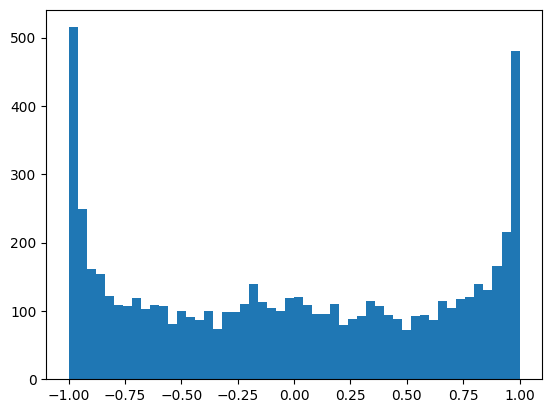

In [48]:
plt.hist(h.view(-1).tolist(), 50)

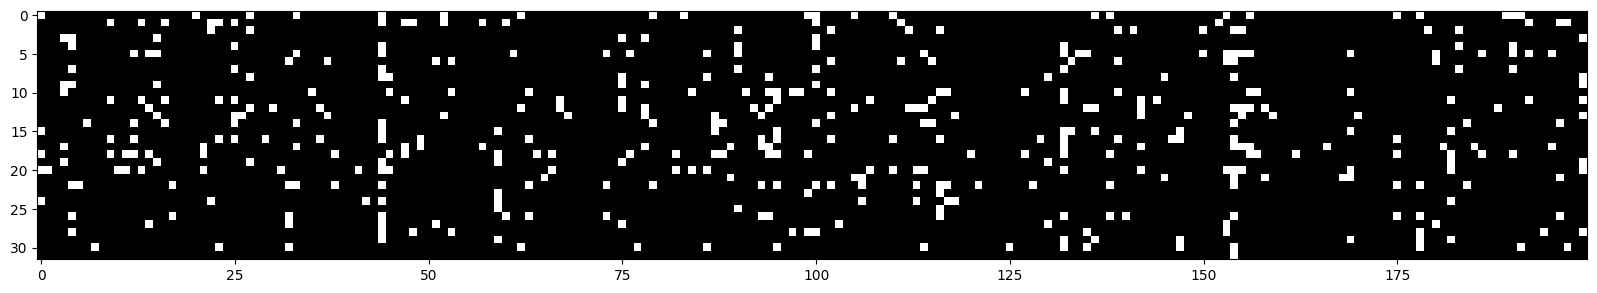

In [49]:
plt.figure(figsize=((20, 10)))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

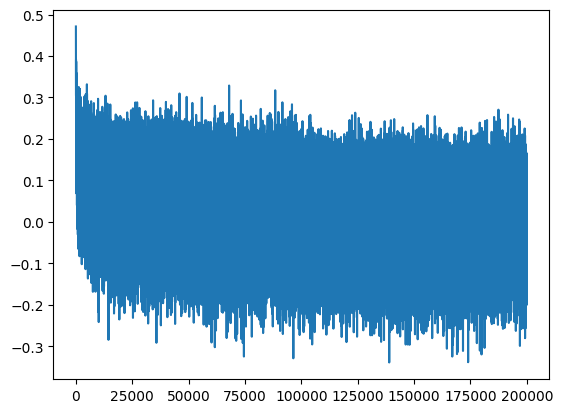

In [50]:
plt.plot(lossi)

In [51]:
# calibrate batch norm

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [52]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    batch_size = 1000 
    losses = []
    
    for i in range(0, x.shape[0], batch_size):
        xb = x[i:i+batch_size]
        yb = y[i:i+batch_size]
        
        # Forward pass 
        emb = C[xb]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact =bngain* (hpreact - bnmean) / bnstd + bnbias
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, yb)
        
        losses.append(loss.item())
    
    # Average the losses from all batches
    total_loss = sum(losses) / len(losses)
    print(split, total_loss)

split_loss('train')
split_loss('val')

train 1.6363056284923136
val 1.6385435390909877


In [13]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    # block_size=3
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor( [context] )] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

CN(C)C1(C)COC(C1)OC1=O.
CC1(C)C2(CO)C#N.
CCC1=NNCC1CC1CO.
O=CC1=NOC=N1.
OCC12OC(=N)C=C1.
CN(C)(O)CC#C.
CC1C2CC(NO)C1=O.
OC1CC1=C(C=N)C2.
CC1CC1C23.
CC1(C)ON=CCC=O3.
COC1CCC(C=O)(N)=C1.
CCC1C2C(O1)C2=NN2CO1.
OCC1(NC1=NO)C2O.
OCC1C2CC3C(C3)NC2C(C#C)N11.
CCOC1=CCC#NC=O.
OC1(COC2)C1C#N.
CC12C3C4(CC41)O.
NC1=C=O.
OCC12COC(C#C)C12.
OC=C1N=C(O)C2C.


In [ ]:
# building a deeper network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __cal__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var 
            
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma + xhat + self.beta
        
        #buffer update
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
     
        